In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr
from sklearn.feature_selection import f_regression, mutual_info_regression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAXResults
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.api as sm
from itertools import product
import pmdarima as pm
import json
import statistics
%matplotlib inline

## Import the dataset. We want obtain an unique dataset where, for each year, we have: annual CO2 emission, solar activity, temperature anomalies

temperautre anomalies data

In [2]:
df_temp=pd.read_csv('annual_csv.csv')
df_temp[:5]

,Source,Year,Mean
0,GCAG,2016,0.9363
1,GISTEMP,2016,0.9900
2,GCAG,2015,0.8998
3,GISTEMP,2015,0.8700
4,GCAG,2014,0.7408


In [3]:
df_temp.dtypes

Source     object
Year        int64
Mean      float64
dtype: object

In [4]:
gistemp=df_temp[df_temp['Source']=='GISTEMP'].sort_values(by='Year')
gistemp[:5]

,Source,Year,Mean
273,GISTEMP,1880,-0.20
271,GISTEMP,1881,-0.12
269,GISTEMP,1882,-0.10
267,GISTEMP,1883,-0.21
265,GISTEMP,1884,-0.28


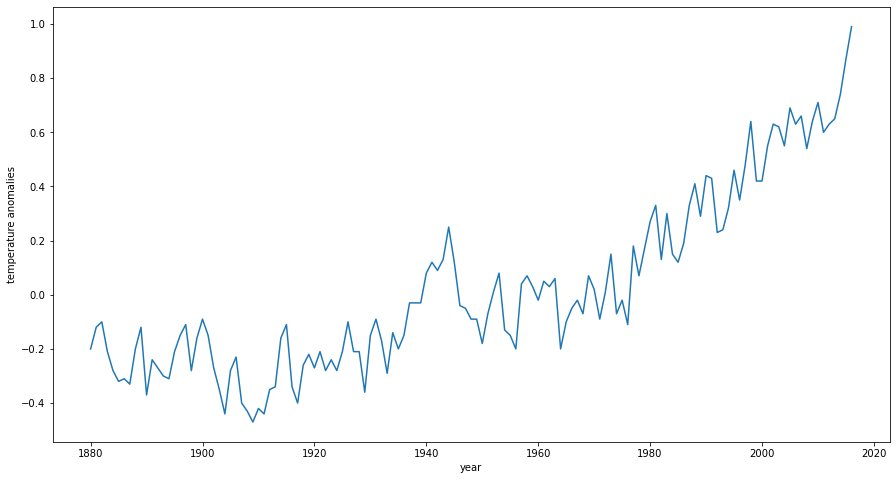

In [5]:
x1=np.array(gistemp['Year'])
T=np.array(gistemp['Mean'])

plt.figure(figsize=(15,8))
plt.plot(x1,T)
plt.xlabel('year')
plt.ylabel('temperature anomalies')
plt.show()

annual co2 emission data

In [6]:
df_co2=pd.read_csv('annual-co2-emissions-per-country (1).csv')
df_co2[:5]

,Entity,Code,Year,Annual CO2 emissions
0,Afghanistan,AFG,1949,14656
1,Afghanistan,AFG,1950,84272
2,Afghanistan,AFG,1951,91600
3,Afghanistan,AFG,1952,91600
4,Afghanistan,AFG,1953,106256


In [7]:
df_co2.dtypes

Entity                  object
Code                    object
Year                     int64
Annual CO2 emissions     int64
dtype: object

In [8]:
#vediamo da che anno a che anno si estende il dataset
print(np.array(df_co2['Year']).min())
print(np.array(df_co2['Year']).max())

1750
2020


In [9]:
df_co2[df_co2['Annual CO2 emissions'].isnull()]

,Entity,Code,Year,Annual CO2 emissions


we have no NaN values under the Annual CO2 emission column

for each yeras, sum all co2 emissions of all nations to obtain the global co2 emission

In [10]:
co2=df_co2[df_co2['Entity']=='World']
co2=co2.drop('Entity',axis=1)
co2=co2.drop('Code',axis=1)
co2.head()

,Year,Annual CO2 emissions
23418,1750,9350528
23419,1751,9350528
23420,1752,9354192
23421,1753,9354192
23422,1754,9357856


In [11]:
co2.columns[1]

'Annual CO2 emissions'

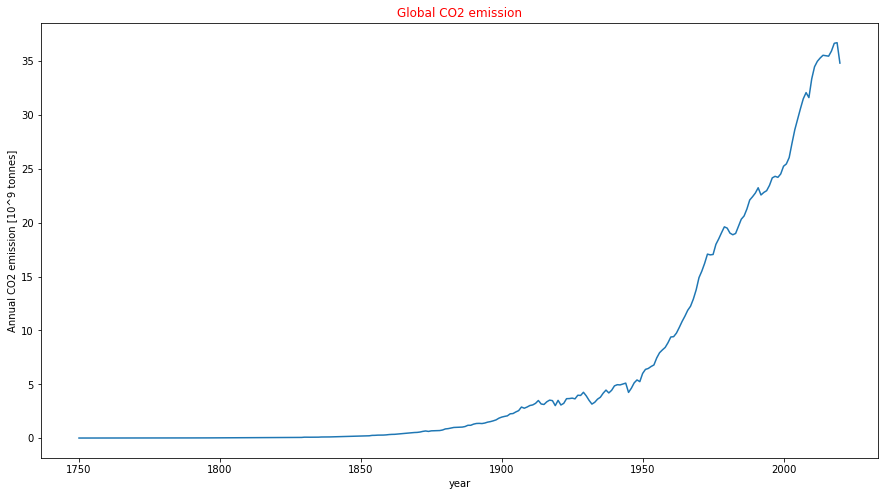

In [12]:
plt.figure(figsize=(15,8))
plt.plot(np.array(co2['Year']),np.array(co2['Annual CO2 emissions'])/1000000000)
plt.xlabel('year')
plt.ylabel('Annual CO2 emission [10^9 tonnes]')
plt.title('Global CO2 emission',color='r')
plt.show()

In [13]:
data=pd.merge(gistemp,co2,on='Year')
data[:5]

,Source,Year,Mean,Annual CO2 emissions
0,GISTEMP,1880,-0.20,853707188
1,GISTEMP,1881,-0.12,882407475
2,GISTEMP,1882,-0.10,931924710
3,GISTEMP,1883,-0.21,991035684
4,GISTEMP,1884,-0.28,1002177745


solar activity data

In [14]:
sun=pd.read_json('observed-solar-cycle-indices.json')
sun.head()

,time-tag,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
0,1749-01,96.7,-1.0,-1.0,-1.0,-1.0,-1.0
1,1749-02,104.3,-1.0,-1.0,-1.0,-1.0,-1.0
2,1749-03,116.7,-1.0,-1.0,-1.0,-1.0,-1.0
3,1749-04,92.8,-1.0,-1.0,-1.0,-1.0,-1.0
4,1749-05,141.7,-1.0,-1.0,-1.0,-1.0,-1.0


In [15]:
sun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time-tag           3276 non-null   object 
 1   ssn                3276 non-null   float64
 2   smoothed_ssn       3276 non-null   float64
 3   observed_swpc_ssn  3276 non-null   float64
 4   smoothed_swpc_ssn  3276 non-null   float64
 5   f10.7              3276 non-null   float64
 6   smoothed_f10.7     3276 non-null   float64
dtypes: float64(6), object(1)
memory usage: 179.3+ KB


In [16]:
if len(np.array(sun['ssn']))==(2021-1749)*12+12:
       print('ci sono tutti i mesi')
else:
       print('qualche mese  è stato saltato')

ci sono tutti i mesi


In [17]:
annual_sun=[round(statistics.mean(map(float,np.array(sun['ssn'])[i:i + 12])),2) for i in range(0, len(sun), 12)]
year=[1749+i for i in range(len(annual_sun))]
sun_df=pd.DataFrame(data=annual_sun,columns=['Annual Sunspots'])
sun_df['Year']=year

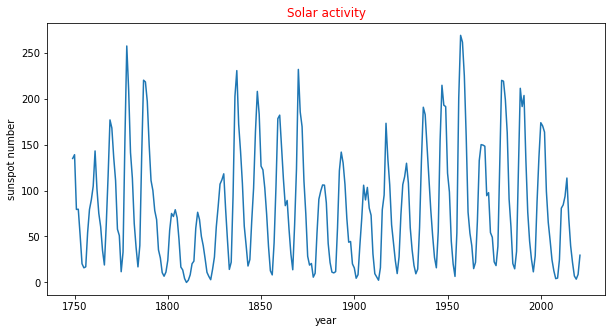

In [18]:
plt.figure(figsize=(10,5))
plt.plot(year,annual_sun)
plt.ylabel('sunspot number')
plt.xlabel('year')
plt.title('Solar activity',color='r')
#plt.xlim(1800,1850)
plt.show()

In [19]:
data=pd.merge(data,sun_df,on='Year')
data[:5]

,Source,Year,Mean,Annual CO2 emissions,Annual Sunspots
0,GISTEMP,1880,-0.20,853707188,53.76
1,GISTEMP,1881,-0.12,882407475,90.51
2,GISTEMP,1882,-0.10,931924710,99.38
3,GISTEMP,1883,-0.21,991035684,106.06
4,GISTEMP,1884,-0.28,1002177745,105.84


In [20]:
data=data.drop('Source',axis=1)
data.set_index('Year',inplace=True)
data.head()

,Mean,Annual CO2 emissions,Annual Sunspots
Year,,,
1880,-0.20,853707188,53.76
1881,-0.12,882407475,90.51
1882,-0.10,931924710,99.38
1883,-0.21,991035684,106.06
1884,-0.28,1002177745,105.84


In [21]:
data.tail()

,Mean,Annual CO2 emissions,Annual Sunspots
Year,,,
2012,0.63,34974075146,84.39
2013,0.65,35283025443,93.71
2014,0.74,35534442952,113.61
2015,0.87,35496406339,69.78
2016,0.99,35452459298,39.83


In [22]:
data.dtypes

Mean                    float64
Annual CO2 emissions      int64
Annual Sunspots         float64
dtype: object

In [23]:
data = data.astype({"Mean": float, "Annual CO2 emissions": float})
data.dtypes

Mean                    float64
Annual CO2 emissions    float64
Annual Sunspots         float64
dtype: object

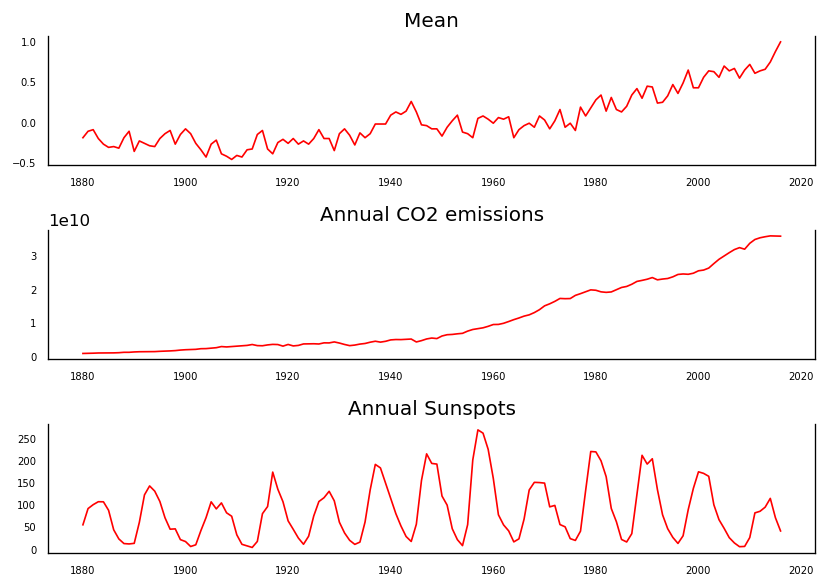

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(7,5))
for i, ax in enumerate(axes.flatten()):
    datas = data[data.columns[i]]
    ax.plot(datas, color='red', linewidth=1)
    ax.set_title(data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

In [25]:
data

,Mean,Annual CO2 emissions,Annual Sunspots
Year,,,
1880,-0.20,8.537072e+08,53.76
1881,-0.12,8.824075e+08,90.51
1882,-0.10,9.319247e+08,99.38
1883,-0.21,9.910357e+08,106.06
1884,-0.28,1.002178e+09,105.84
...,...,...,...
2012,0.63,3.497408e+10,84.39
2013,0.65,3.528303e+10,93.71
2014,0.74,3.553444e+10,113.61


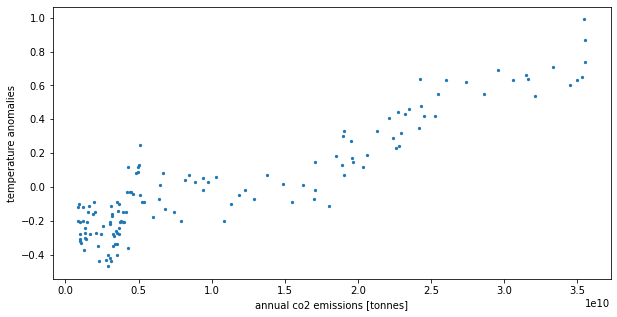

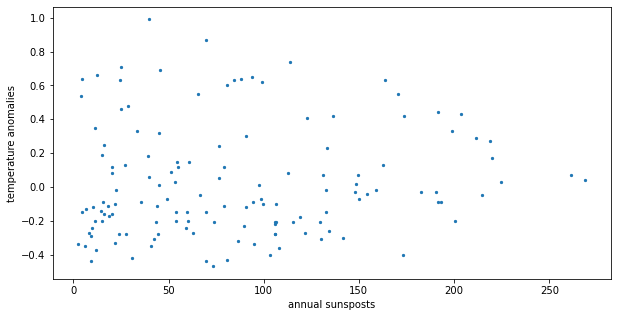

In [26]:
T=np.array(data['Mean'])
co2=np.array(data['Annual CO2 emissions'])
plt.figure(figsize=(10,5))
plt.scatter(co2,T,s=5) #se faccio scatter il np.sort() non è necessario, se voglio fare plt.plot invece è utile farlo
plt.xlabel('annual co2 emissions [tonnes]')
plt.ylabel('temperature anomalies')
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(np.array(data['Annual Sunspots']),T,s=5) #se faccio scatter il np.sort() non è necessario, se voglio fare plt.plot invece è utile farlo
plt.xlabel('annual sunsposts')
plt.ylabel('temperature anomalies')
plt.show()

Spearman rank-order correlation test
------

co2 and temperature correlation

In [27]:
level=0.01
corr, p_value = spearmanr(co2, T)
print(f' Spearman correlation degree: {corr.round(2)}')
if p_value<level:
    print('rigetto ipotesi nulla')
    print(f'p value: {p_value}')

 Spearman correlation degree: 0.87
rigetto ipotesi nulla
p value: 5.866665028465032e-44


we can therefore reject the null hypothesis of Sperman's test, i.e. that there is no correlation, with a confidence level of 1%. 

solar activity and temperature correlation

In [28]:
level=0.01
corr, p_value = spearmanr(np.array(data['Annual Sunspots']), T)
print(f' Spearman correlation degree: {corr.round(2)}')
if p_value<level:
    print('rigetto ipotesi nulla')
    print(f'p value: {p_value}')
else:
    print('non posso rigettare ipotesi nulla')
    print(f'p value: {p_value}')

 Spearman correlation degree: 0.13
non posso rigettare ipotesi nulla
p value: 0.11653351316235154


there is about 89% of probability to have a correlation. However the correlation is very small (0.13) so we can be confident that there is no significant correlation. 

Mutual information
-----------


In [29]:
def MI(x,y):
    #print(f'mutual information: {mutual_info_regression(x.reshape(-1,1),y)[0]}')
    return mutual_info_regression(x.reshape(-1,1),y)[0]

mutual information between co2 emission and temperature:

In [30]:
print(f'mutual info: {MI(co2,T)}')

mutual info: 1.1073431022849745


In [31]:
N=1000
mi_random=[]
for i in range(N):
    np.random.shuffle(T)
    mi_random.append(MI(np.sort(co2),T))

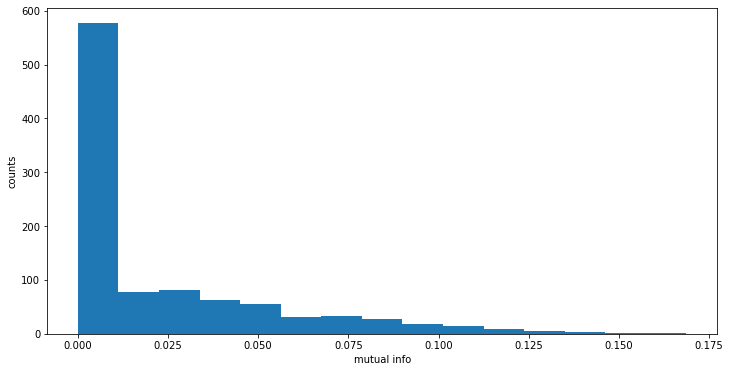

In [32]:
plt.figure(figsize=(12,6))
plt.hist(mi_random,bins=15)
plt.xlabel('mutual info')
plt.ylabel('counts')
plt.show()

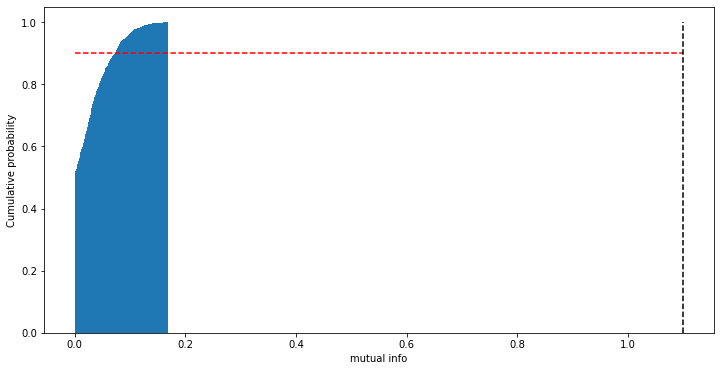

In [33]:
plt.figure(figsize=(12,6))
plt.hist(mi_random,bins=100,density=True,cumulative=True)
plt.hlines(0.9,xmin=0,xmax=1.1,color='r',linestyles='dashed')
plt.vlines(1.1,ymin=0,ymax=1,color='black',linestyles='dashed')
plt.ylabel('Cumulative probability')
plt.xlabel('mutual info')
plt.show()

mutual information computed is highly significative.

mutual information between solar activity and temperature:

In [34]:
mi=MI(np.array(data['Annual Sunspots']),T)
print(f'mutual info: {mi}')

mutual info: 0


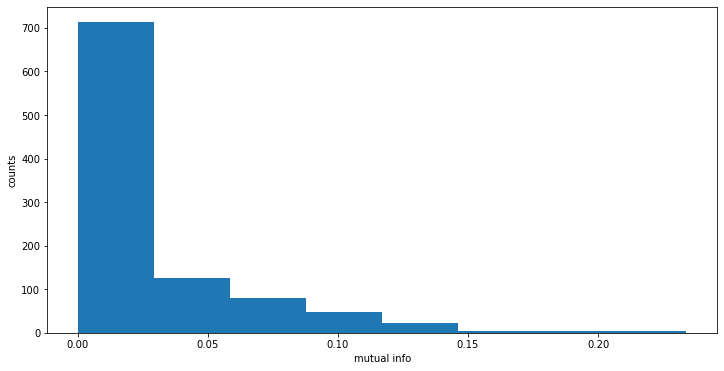

In [35]:
N=1000
mi_random=[]
for i in range(N):
    np.random.shuffle(T)
    mi_random.append(MI(np.array(data['Annual Sunspots']),T))
plt.figure(figsize=(12,6))
plt.hist(mi_random,bins=8)
plt.xlabel('mutual info')
plt.ylabel('counts')
plt.show()

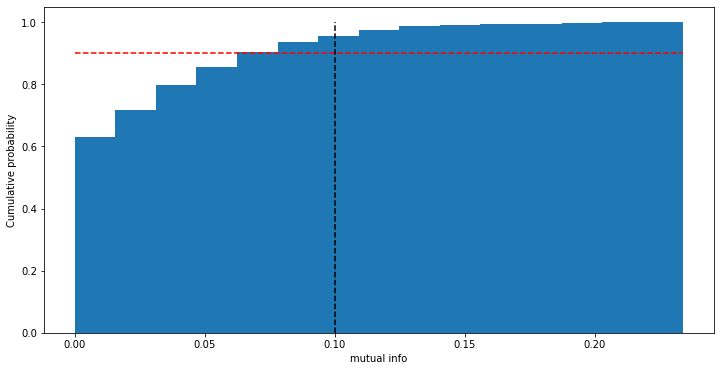

In [36]:
plt.figure(figsize=(12,6))
n,b,p=plt.hist(mi_random,bins=15,density=True,cumulative=True)
plt.hlines(0.90,xmin=b[0],xmax=b[-1],color='r',linestyles='dashed')
plt.vlines(0.1,ymin=0,ymax=n[-1],color='black',linestyles='dashed')
plt.ylabel('Cumulative probability')
plt.xlabel('mutual info')
plt.show()

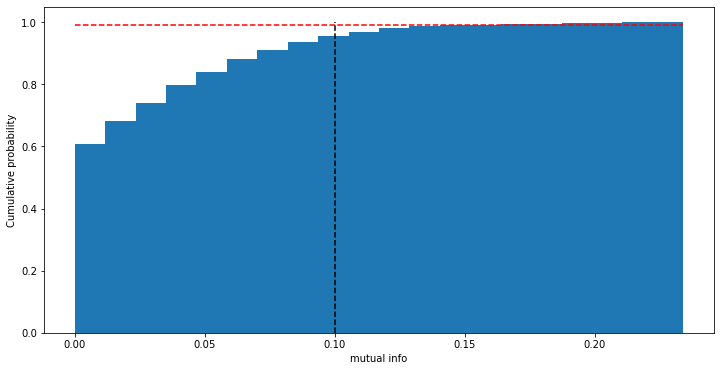

In [37]:
plt.figure(figsize=(12,6))
n,b,p=plt.hist(mi_random,bins=20,density=True,cumulative=True)
plt.hlines(0.99,xmin=b[0],xmax=b[-1],color='r',linestyles='dashed')
plt.vlines(0.1,ymin=0,ymax=n[-1],color='black',linestyles='dashed')
plt.ylabel('Cumulative probability')
plt.xlabel('mutual info')
plt.show()

mutual information computed is significative for 10% significance level, not for 1% instead.

Delay mutual information
---------

shift forward the temperature array: we are looking the correlation between the actual co2 emission values with the future values of temperature anomalies.

In [38]:
T = np.array(data["Mean"])

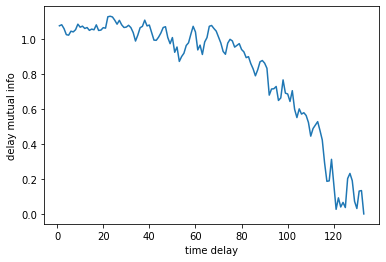

In [39]:
TAU=[]
del_mi=[]
for tau in range(1,len(T)): #per ogni time delay 
    if len(T[:-tau])>3:
        #print(tau)
        TAU.append(tau)
        del_mi.append(MI(T[tau:],np.sort(co2)[:-tau]))
        #del_mi.append(MI(np.sort(co2)[tau:],T[:-tau]))
    else:
        break
plt.plot(TAU,del_mi)
plt.xlabel('time delay')
plt.ylabel('delay mutual info')
plt.show()

now we look at the correlation between the actual temperature anomalies and the future values of co2 emission. We expect that this correlation quickly drop to zero.

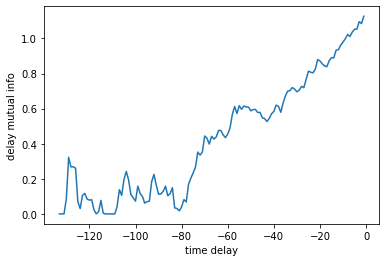

In [40]:
TAU_neg=[]
del_mi_neg=[]
for tau in range(1,len(T)):
    if len(T[:-tau])>3:
        TAU_neg.append(-tau)
        del_mi_neg.append(MI(np.sort(co2)[tau:],T[:-tau]))
        #del_mi_neg.append(MI(T[tau:],np.sort(co2)[:-tau]))
    else:
        break
plt.plot(TAU_neg,del_mi_neg)
plt.xlabel('time delay')
plt.ylabel('delay mutual info')
plt.show()

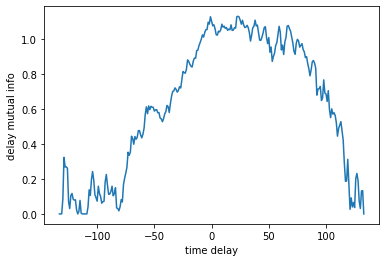

In [41]:
tau=np.array(list(np.flipud(TAU_neg))+list(TAU))
dim=np.array(list(np.flipud(del_mi_neg))+list(del_mi))
#dim=np.array(del_mi_neg+del_mi)
plt.plot(tau,dim)
plt.xlabel('time delay')
plt.ylabel('delay mutual info')
plt.show()

Granger causality
======

split the dataset in training e test set

In [42]:
data=data[['Mean','Annual CO2 emissions','Annual Sunspots']]
n_obs=10
df_train, df_test = data[:-n_obs], data[-n_obs:]

Stationarity study
---------

Adfuller test

In [43]:
#adfuller co2
result = adfuller(df_train[['Mean']])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")
print('===============================================================================')
#adfuller T
result = adfuller(df_train[['Annual CO2 emissions']])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")
print('===============================================================================')
result = adfuller(df_train[['Annual Sunspots']])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")


Test Statistics: 0.5220613928971526
p-value: 0.9855284322774177
critical_values: {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}
Series is not stationary
Test Statistics: 3.762798005162633
p-value: 1.0
critical_values: {'1%': -3.4837793736959997, '5%': -2.88495387648, '10%': -2.579256976}
Series is not stationary
Test Statistics: -1.9433007716098945
p-value: 0.3119730764141553
critical_values: {'1%': -3.4880216384691867, '5%': -2.8867966864160075, '10%': -2.5802408234244947}
Series is not stationary


Le serie non sono stazionarie: proviamo a renderle stazionarie con una prima differenziazione

First difference

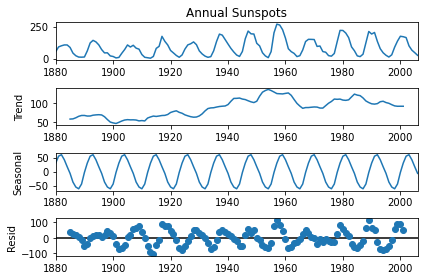

In [44]:
#prima vediamo che per far diventare stazionaria la terza serie dobbiamo fare la differenza tenendo conto della stazionarietà
decomposition = seasonal_decompose(df_train['Annual Sunspots'].dropna(), model='additive', period=11)
decomposition.plot()
plt.show()

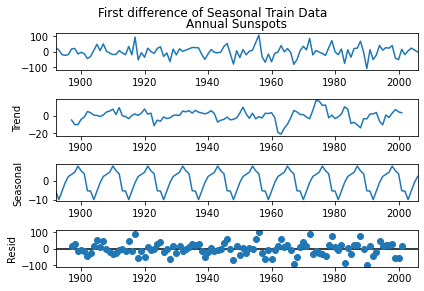

In [45]:
Train_seasonal_difference = df_train['Annual Sunspots'] - df_train['Annual Sunspots'].shift(11)
#Train_seasonal_difference = Train_seasonal_difference - Train_seasonal_difference.shift(11)
Train_seasonal_first_difference = Train_seasonal_difference - Train_seasonal_difference.shift(1)
decomposition_2=seasonal_decompose(Train_seasonal_first_difference.dropna(), model='additive', period =11)
decomposition_2.plot()
plt.suptitle('First difference of Seasonal Train Data', y=1)
plt.show()

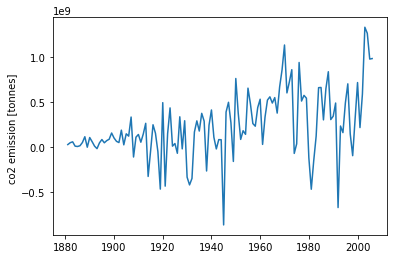

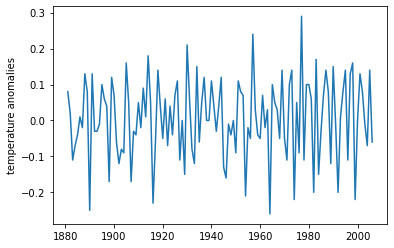

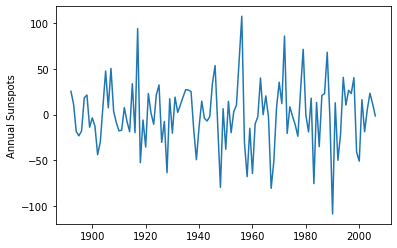

In [46]:
df_differenced = df_train.diff().dropna()
plt.plot(df_differenced['Annual CO2 emissions'])
plt.ylabel('co2 emission [tonnes] ')
plt.show()
plt.plot(df_differenced['Mean'])
plt.ylabel('temperature anomalies')
plt.show()
plt.plot(Train_seasonal_first_difference.dropna())
plt.ylabel('Annual Sunspots')
plt.show()

adfuller test again

In [47]:
#adfuller co2
result = adfuller(df_differenced['Annual CO2 emissions'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")
print('===============================================================================')
#adfuller T
result = adfuller(df_differenced['Mean'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")
print('===============================================================================')
result = adfuller(Train_seasonal_first_difference.dropna())
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

Test Statistics: -3.2592998301809577
p-value: 0.016798732003100874
critical_values: {'1%': -3.4846672514209773, '5%': -2.8853397507076006, '10%': -2.5794629869786503}
Series is stationary
Test Statistics: -7.037432266123737
p-value: 5.965888608882625e-10
critical_values: {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}
Series is stationary
Test Statistics: -4.671484110502423
p-value: 9.516865135306303e-05
critical_values: {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}
Series is stationary


## test if CO2 emission Granger causes temperature anomalies

In [48]:
grangercausalitytests(df_differenced[['Mean','Annual CO2 emissions']], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4843  , p=0.0362  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.5946  , p=0.0321  , df=1
likelihood ratio test: chi2=4.5121  , p=0.0337  , df=1
parameter F test:         F=4.4843  , p=0.0362  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4737  , p=0.0886  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=5.1553  , p=0.0760  , df=2
likelihood ratio test: chi2=5.0510  , p=0.0800  , df=2
parameter F test:         F=2.4737  , p=0.0886  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0902  , p=0.1053  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=6.6490  , p=0.0840  , df=3
likelihood ratio test: chi2=6.4755  , p=0.0906  , df=3
parameter F test:         F=2.0902  , p=0.1053  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6252  , p=0.1728  

{1: ({'ssr_ftest': (4.484282686789139, 0.03623782519773933, 122.0, 1),
   'ssr_chi2test': (4.594551933185593, 0.03207372543922793, 1),
   'lrtest': (4.5121260224613025, 0.033655383194936245, 1),
   'params_ftest': (4.484282686789155, 0.03623782519773912, 122.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.473703675502568, 0.08859640734967528, 119.0, 2),
   'ssr_chi2test': (5.15528160945073, 0.07595298073256786, 2),
   'lrtest': (5.050997183873051, 0.08001840630686452, 2),
   'params_ftest': (2.473703871898762, 0.08859639064420739, 119.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.090196363885401, 0.1053116633679922, 116.0, 3),
   'ssr_chi2test': (6.648986709256146, 0.08396842891174917, 3),
   'lrtest': (6.475499942454917, 0.0906337495115367, 3),
   'params_ftest': (2.090195158403534, 0.10531182194108007, 116.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0

## test if temperature anomalies Granger causes CO2 emission (obviously we expect not)

In [49]:
grangercausalitytests(df_differenced[['Annual CO2 emissions','Mean']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1698  , p=0.6810  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1740  , p=0.6766  , df=1
likelihood ratio test: chi2=0.1739  , p=0.6767  , df=1
parameter F test:         F=0.1698  , p=0.6810  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2087  , p=0.8119  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.4350  , p=0.8045  , df=2
likelihood ratio test: chi2=0.4343  , p=0.8048  , df=2
parameter F test:         F=0.2087  , p=0.8119  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6324  , p=0.5955  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=2.0118  , p=0.5700  , df=3
likelihood ratio test: chi2=1.9955  , p=0.5733  , df=3
parameter F test:         F=0.6324  , p=0.5955  , df_denom=116, df_num=3


{1: ({'ssr_ftest': (0.16984129096092548, 0.6809761189088129, 122.0, 1),
   'ssr_chi2test': (0.1740177161484892, 0.6765655442937355, 1),
   'lrtest': (0.17389669978911115, 0.6766716548557485, 1),
   'params_ftest': (0.16984129096096245, 0.6809761189087888, 122.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.2087363580474399, 0.8119057066443623, 119.0, 2),
   'ssr_chi2test': (0.43501358651903443, 0.8045221395735827, 2),
   'lrtest': (0.4342523147533939, 0.8048284278568852, 2),
   'params_ftest': (0.20873635804745586, 0.8119057066443516, 119.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.6324258883952101, 0.5955482282427463, 116.0, 3),
   'ssr_chi2test': (2.0117685587744183, 0.5699676927183999, 3),
   'lrtest': (1.9954936941112464, 0.5733425317962275, 3),
   'params_ftest': (0.6324258883952004, 0.5955482282427548, 116.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.,

## test if Solar activity Granger causes temperature anomalies

In [50]:
grangercausalitytests(df_differenced[['Mean','Annual Sunspots']].dropna(), maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2476  , p=0.6197  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2536  , p=0.6145  , df=1
likelihood ratio test: chi2=0.2534  , p=0.6147  , df=1
parameter F test:         F=0.2476  , p=0.6197  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1639  , p=0.8490  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.3416  , p=0.8430  , df=2
likelihood ratio test: chi2=0.3412  , p=0.8432  , df=2
parameter F test:         F=0.1639  , p=0.8490  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1415  , p=0.9349  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=0.4501  , p=0.9297  , df=3
likelihood ratio test: chi2=0.4493  , p=0.9299  , df=3
parameter F test:         F=0.1415  , p=0.9349  , df_denom=116, df_num=3


{1: ({'ssr_ftest': (0.24755167084976076, 0.6196998990200933, 122.0, 1),
   'ssr_chi2test': (0.2536390070181975, 0.6145243166362527, 1),
   'lrtest': (0.2533820236080828, 0.6147036941797588, 1),
   'params_ftest': (0.24755167084976748, 0.6196998990200837, 122.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.1639259566255119, 0.8489962091519068, 119.0, 2),
   'ssr_chi2test': (0.3416272037237559, 0.8429786884862024, 2),
   'lrtest': (0.34115746490124366, 0.8431767016471755, 2),
   'params_ftest': (0.16392595662558737, 0.8489962091518394, 119.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.14148956265289164, 0.9349230841831444, 116.0, 3),
   'ssr_chi2test': (0.45008317774928464, 0.9297127919145384, 3),
   'lrtest': (0.44926170603071114, 0.9298883034488074, 3),
   'params_ftest': (0.1414895626527711, 0.9349230841832237, 116.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0